In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
!pip3 install gym --upgrade

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
import cv2

from collections import namedtuple
from dataclasses import dataclass, field
import random

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [5]:
display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1013'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1013'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [6]:
torch.cuda.is_available()

False

In [ ]:
env = gym.make("CartPole-v0")
env.reset()

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  if done:
    break

env.close()

In [8]:
# explore the env

env.action_space.n, env.observation_space

(2,
 Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32))

**This is what the input to the net looks like.**



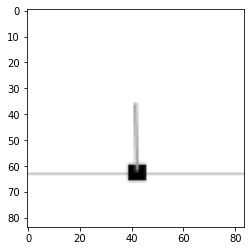

In [9]:
env.reset()
gray_scale = cv2.cvtColor(env.render("rgb_array"), cv2.COLOR_RGB2GRAY)
gray_scale_cropped = cv2.resize(gray_scale, (84, 84), interpolation=cv2.INTER_AREA)
plt.imshow(gray_scale_cropped, cmap="gray")

# note that we don't need to stack the frames together as was done in the paper,
# because one frame contains all the information needed to get a feel of what is going on.

In [10]:
# torch.flatten(torch.from_numpy(gray_scale_cropped)).shape, 84*84
# torch.from_numpy(gray_scale_cropped)
torch.Tensor(gray_scale_cropped)

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])

In [11]:
class DQN(nn.Module):
    
    def __init__(self, width, height):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=width*height, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
        
    def forward(self, t):
        t = t.flatten()
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [12]:
network = DQN(84, 84)
network(torch.from_numpy(gray_scale_cropped.astype(np.float32)))

tensor([-29.3579,  -5.2958], grad_fn=<AddBackward0>)

In [13]:
Experiance = namedtuple(
    "Experiances",
    ("action", "state", "next_state", "reward")
)

In [14]:
Experiance(1, 2, 3, 4)[2]

3

In [15]:
@dataclass(init=True, repr=False)
class ReplayMemory:
    
    """
        ReplayMemory class is for handling the replay memory data and sample batch_size samples for training.
    """
    
    capacity: int
    memory: list = field(default_factory=list)
    push_count: int = 0
        
    def push(self, exp):
        if len(self.memory) < self.capacity:
            self.memory.append(exp)
        else:
            self.memory[self.push_count % self.capacity] = exp
        self.push_count += 1
        
    def sample(self, batch_size):
        return [self.memory[i] for i in np.random.permutation(len(self.memory))[:batch_size]]
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [16]:
@dataclass(init=True)
class EpGreedy:
    
    start: int
    end: int
    decay: int
        
    def get_exploration_rate(self, current_step):
#         if current_step - self.decay >= self.end:
#             return current_step - self.decay
#         return current_step
        return self.end + (self.start - self.end) * np.exp(-1 * current_step * self.decay)

In [17]:
ep_greedy = EpGreedy(1, 0.2, 0.001)

In [18]:
ep_greedy.get_exploration_rate(300)

0.7926545765453743

**RL Agent**

In [19]:
class Agent:
    
    def __init__(self, strategy, num_actions):
        self.strategy = strategy
        self.num_actions = num_actions
        self.current_step = 0
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            return np.random.choice(self.num_actions) # explore
        else:
            with torch.no_grad():
                # print(policy_net(state))
                return policy_net(state).argmax(dim=0).item() # exploit

In [20]:
class EnvManager:
    
    def __init__(self):
        self.env = gym.make('CartPole-v0').unwrapped
        self.agent = Agent(EpGreedy(1, 0.2, 0.001), self.env.action_space.n)
        self.width = 84
        self.height = 84
        self.discount_factor = 0.95
        self.policy_network = DQN(self.width, self.height)
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=0.02)
        # self.target_network = None

        self.replay_memory = ReplayMemory(30)
        
    def preprocess_input(self):
        gray_scale = cv2.cvtColor(self.env.render("rgb_array"), cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray_scale, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return torch.from_numpy(resized.astype(np.float32))

    def replay_memory_gradient_descent(self, batch_size):
        if self.replay_memory.can_provide_sample(batch_size):
            experiments = self.replay_memory.sample(batch_size)
            for exp in experiments:

                action, state, new_state, reward = exp

                with torch.no_grad():
                    optimal_q_value = reward + self.discount_factor * self.policy_network(new_state).max().item()

                self.optimizer.zero_grad()
                q_value = self.policy_network(state)[action]
                loss = torch.square(optimal_q_value - q_value)
                loss.backward()

                self.optimizer.step()


    def train_algorithm(self):

        episodes = 10000
        max_steps = 20

        # episodes
        for ep in range(episodes):

            print(f"********Ep {ep+1}********")

            total_reward = 0
            total_loss = 0

            self.env.reset()
            current_state = self.preprocess_input()

            for step in range(max_steps):

                # print(current_state.shape)

                action = self.agent.select_action(current_state, self.policy_network)

                _, reward, done, _ = self.env.step(action)

                new_state = self.preprocess_input()

                self.replay_memory.push(Experiance(action, current_state, new_state, reward))

                self.replay_memory_gradient_descent(16)

                total_reward += reward
                with torch.no_grad():
                    optimal_q_value = reward + self.discount_factor * self.policy_network(new_state).max().item()
                    q_value = self.policy_network(current_state)[action].item()
                    loss = optimal_q_value - q_value
                    total_loss += loss

                current_state = new_state

                if done:
                    break

            print("Exp rate", self.agent.strategy.get_exploration_rate(self.agent.current_step))
            print("total reward", total_reward)
            print("total loss", total_loss)

In [21]:
em = EnvManager()
em.train_algorithm()

********Ep 1********
Exp rate 0.9880895516824502
total reward 15.0
total loss -30.4605491638184
********Ep 2********
Exp rate 0.9786889932194696
total reward 12.0
total loss 2.051495790481562
********Ep 3********
Exp rate 0.963269918072297
total reward 20.0
total loss 4.1103363042083174e-05
********Ep 4********
Exp rate 0.9481561610694214
total reward 20.0
total loss -1.3351440415476645e-05
********Ep 5********
Exp rate 0.9333416765065219
total reward 20.0
total loss -1.3351440415476645e-05
********Ep 6********
Exp rate 0.9238699344287677
total reward 13.0
total loss -8.67843627005982e-06
********Ep 7********
Exp rate 0.9095363493737261
total reward 20.0
total loss -1.3351440415476645e-05
********Ep 8********
Exp rate 0.8954865883190448
total reward 20.0
total loss -1.3351440415476645e-05
********Ep 9********
Exp rate 0.8878781589273645
total reward 11.0
total loss -7.343292228512155e-06
********Ep 10********
Exp rate 0.8742572587772959
total reward 20.0
total loss -1.3351440415476645e

KeyboardInterrupt: ignored

In [ ]:
# np.random.permutation(15)
torch.tensor([[1, 2], [1, 2]])

In [65]:
np.random.choice([Experiance(1, 23, 4, 3), Experiance(1, 23, 4, 3)], 2)

ValueError: ignored